## IMPUTED SQL - PYTHON PIPELINE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine , text
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import date
import datetime
import time
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import mlflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
server = 'DESKTOP-9ASSRIE\SQLEXPRESS'
database = 'PAI_CA1_IMPUTED'
packages = ['sqlalchemy', 'pyodbc']
engine = create_engine('mssql+pyodbc://{}/{}?driver=SQL Server'.format(server, database))

In [3]:
%%time

## establish connection to database
connection = engine.connect()

## obtain Sensor Data and store in DataFrames
cursor = connection.execute(text('SELECT * FROM Sensor'))
sensor = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## obtain Driver Data
cursor = connection.execute(text('SELECT * FROM Driver'))
driver = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## obtain Safety Data
cursor = connection.execute(text('SELECT * FROM Safety'))
safety = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

## close connection to database
connection.close()

CPU times: total: 36.5 s
Wall time: 36.6 s


In [4]:
sensor

,bookingID,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed
0,0.000000e+00,8.000,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
1,0.000000e+00,8.000,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
2,0.000000e+00,8.000,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454
3,0.000000e+00,8.000,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.228454
4,0.000000e+00,8.000,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.228454
...,...,...,...,...,...,...,...,...,...,...,...
7459891,9.964324e+11,3.712,87.000000,-1.908237,8.988108,2.710319,-0.105388,0.442492,0.058795,1538.0,3.574830
7459892,9.964324e+11,3.649,64.000000,-0.909824,8.722343,2.320052,-0.120659,0.332536,0.089949,1539.0,3.235918
7459893,9.964324e+11,3.462,42.000000,-2.490046,9.490906,-0.502798,0.061379,0.327038,0.042912,1540.0,2.388671
7459894,9.964324e+11,3.620,3.000000,-1.498816,10.146936,-0.668003,0.135293,0.243350,0.093003,1542.0,3.794280


In [5]:
safety

,bookingID,driverID,label
0,0.000000e+00,48.0,0
1,1.000000e+00,74.0,1
2,1.000000e+01,75.0,0
3,1.005022e+12,64.0,1
4,1.005022e+12,49.0,1
...,...,...,...
19995,9.964324e+11,57.0,0
19996,9.964324e+11,27.0,0
19997,9.964324e+11,70.0,0
19998,9.964324e+11,87.0,0


In [6]:
driver

,driverID,name,date_of_birth,gender,car_model,car_make_year,rating
0,1.0,Tressa,1992-01-12,Female,Mazda,2011,4.5
1,2.0,Virgilio,1992-10-23,Male,Mazda,2004,3.5
2,3.0,Bert,1989-08-10,Male,Nissan,2008,4.5
3,4.0,Mahmoud,1981-08-14,Male,Toyota,2008,4.5
4,5.0,Felecia,1990-07-20,Female,Hyundai,2010,4.5
...,...,...,...,...,...,...,...
143,144.0,Adena,1982-12-31,Female,Chevrolet,2011,4.0
144,145.0,Shari,1992-11-19,Female,Mazda,2011,5.0
145,146.0,Sid,1984-06-29,Male,Volkswagen,2010,5.0
146,147.0,Delila,1982-11-08,Female,Toyota,2011,3.0


## Merge DF By BookingID + Column Aggregation

In [7]:
merged_1 = pd.merge(safety, driver, on='driverID')
merged_1 = merged_1.drop(columns=['driverID', 'name'])
merged_df = pd.merge(sensor, merged_1, on='bookingID')

In [8]:
merged_df

,bookingID,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,label,date_of_birth,gender,car_model,car_make_year,rating
0,0.000000e+00,8.000,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
1,0.000000e+00,8.000,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
2,0.000000e+00,8.000,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
3,0.000000e+00,8.000,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
4,0.000000e+00,8.000,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.228454,0,1974-08-13,Male,Mercedes-Benz,2013,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7459891,9.964324e+11,3.712,87.000000,-1.908237,8.988108,2.710319,-0.105388,0.442492,0.058795,1538.0,3.574830,1,1991-08-27,Male,Chevrolet,2008,3.5
7459892,9.964324e+11,3.649,64.000000,-0.909824,8.722343,2.320052,-0.120659,0.332536,0.089949,1539.0,3.235918,1,1991-08-27,Male,Chevrolet,2008,3.5
7459893,9.964324e+11,3.462,42.000000,-2.490046,9.490906,-0.502798,0.061379,0.327038,0.042912,1540.0,2.388671,1,1991-08-27,Male,Chevrolet,2008,3.5
7459894,9.964324e+11,3.620,3.000000,-1.498816,10.146936,-0.668003,0.135293,0.243350,0.093003,1542.0,3.794280,1,1991-08-27,Male,Chevrolet,2008,3.5


In [9]:
male = merged_df[merged_df['gender'] == 'Male']
female = merged_df[merged_df['gender'] == 'Female']


print('total males: ' + str(len(male)))
print('total females: ' + str(len(female)))

total males: 4669241
total females: 2790655


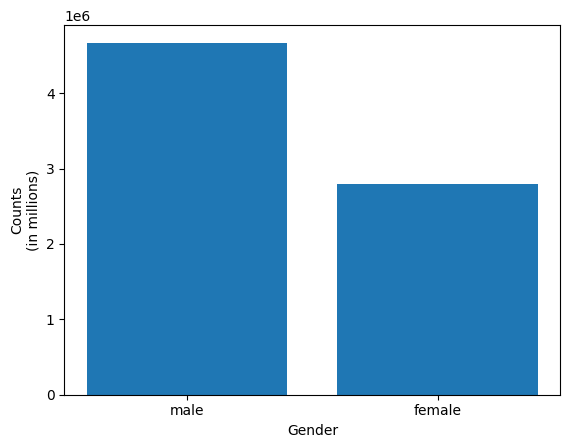

In [10]:
values = [len(male), len(female)]
genders = ['male', 'female']

plt.bar(genders, values)
plt.xlabel('Gender')
plt.ylabel('Counts\n(in millions)')
plt.show()

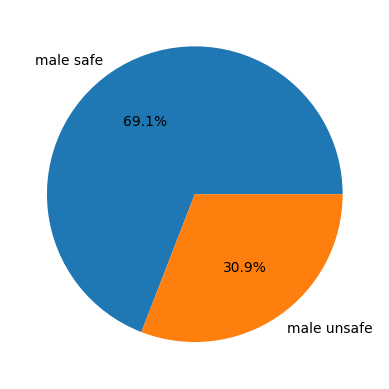

In [11]:
male = merged_df[merged_df['gender'] == 'Male']
male_safe = len(male[male['label'] == 0])
male_unsafe = len(male[male['label'] == 1])

pieVals = [male_safe, male_unsafe]
labels = ['male safe', 'male unsafe']
plt.pie(pieVals, labels=labels, autopct='%1.1f%%')
plt.show()

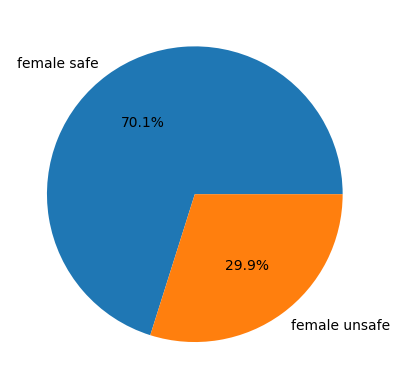

In [12]:
female = merged_df[merged_df['gender'] == 'Female']
female_safe = len(female[female['label'] == 0])
female_unsafe = len(female[female['label'] == 1])

pieVals = [female_safe, female_unsafe]
labels = ['female safe', 'female unsafe']
plt.pie(pieVals, labels=labels, autopct='%1.1f%%')
plt.show()

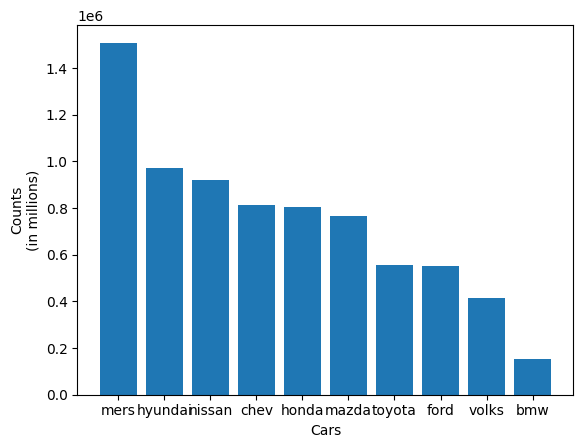

In [13]:
counts = merged_df['car_model'].value_counts()
car_names = ['mers', 'hyundai', 'nissan', 'chev', 'honda', 'mazda', 'toyota', 'ford', 'volks', 'bmw']

plt.bar(car_names, counts)
plt.xlabel('Cars')
plt.ylabel('Counts\n(in millions)')
plt.show()

mers unsafe: 0.30414885216855403
hyundai unsafe: 0.31223960254802136
nissan unsafe: 0.2901205810705788
chev unsafe: 0.27846635586552027
honda unsafe: 0.32078279322950354
mazda unsafe: 0.30378987081285014
toyota unsafe: 0.3076365834373341
ford unsafe: 0.3160799732831
volks unsafe: 0.3084180799679017
bmw unsafe: 0.30302811303028115


Text(0, 0.5, 'Percentage Of Unsafe Incidents')

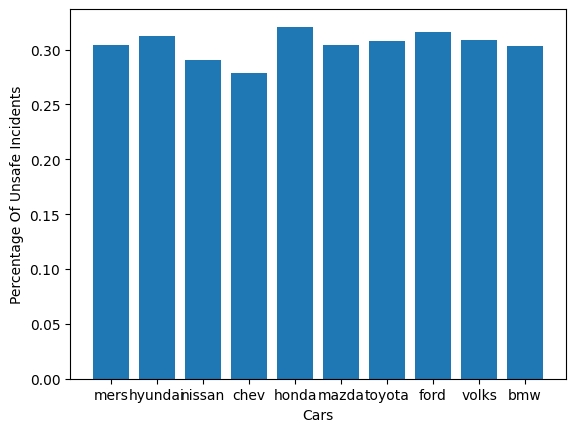

In [14]:
mers = merged_df[merged_df['car_model'] == 'Mercedes-Benz']
hyundai = merged_df[merged_df['car_model'] == 'Hyundai']
nissan = merged_df[merged_df['car_model'] == 'Nissan']
chev = merged_df[merged_df['car_model'] == 'Chevrolet']
honda = merged_df[merged_df['car_model'] == 'Honda']
mazda = merged_df[merged_df['car_model'] == 'Mazda']
toyota = merged_df[merged_df['car_model'] == 'Toyota']
ford = merged_df[merged_df['car_model'] == 'Ford']
volks = merged_df[merged_df['car_model'] == 'Volkswagen']
bmw = merged_df[merged_df['car_model'] == 'BMW']

cars = [mers, hyundai, nissan, chev, honda, mazda, toyota, ford, volks, bmw]
car_names = ['mers', 'hyundai', 'nissan', 'chev', 'honda', 'mazda', 'toyota', 'ford', 'volks', 'bmw']
values = []

for car in range(len(cars)):
    curr = cars[car]
    curr_name = car_names[car]
    unsafe = len(curr[curr['label'] == 1])
    print(f'{curr_name} unsafe: {unsafe/len(curr)}')
    values.append(unsafe/len(curr))


plt.bar(car_names, values)
plt.xlabel('Cars')
plt.ylabel('Percentage Of Unsafe Incidents')

In [15]:
merged_df = merged_df.drop(columns = ["car_model","gender"])

In [16]:
# convert date_of_birth into driver's age
dob = merged_df['date_of_birth']
ageArr = []

for date in range(len(dob)):
    age = 2019 - int(dob[date][0:4])
    ageArr.append(age)

# replace date_of_birth column with age
merged_df['date_of_birth'] = ageArr

merged_df

,bookingID,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,label,date_of_birth,car_make_year,rating
0,0.000000e+00,8.000,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0,45,2013,4.0
1,0.000000e+00,8.000,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0,45,2013,4.0
2,0.000000e+00,8.000,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,0,45,2013,4.0
3,0.000000e+00,8.000,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.228454,0,45,2013,4.0
4,0.000000e+00,8.000,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.228454,0,45,2013,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7459891,9.964324e+11,3.712,87.000000,-1.908237,8.988108,2.710319,-0.105388,0.442492,0.058795,1538.0,3.574830,1,28,2008,3.5
7459892,9.964324e+11,3.649,64.000000,-0.909824,8.722343,2.320052,-0.120659,0.332536,0.089949,1539.0,3.235918,1,28,2008,3.5
7459893,9.964324e+11,3.462,42.000000,-2.490046,9.490906,-0.502798,0.061379,0.327038,0.042912,1540.0,2.388671,1,28,2008,3.5
7459894,9.964324e+11,3.620,3.000000,-1.498816,10.146936,-0.668003,0.135293,0.243350,0.093003,1542.0,3.794280,1,28,2008,3.5


In [17]:
# aggregate to get mean, median, min max of most columns
merged_df = merged_df.groupby('bookingID').agg({
     'accuracy': ['mean', 'median', 'min', 'max'],
     'bearing': ['mean', 'median', 'min', 'max'],
     'acceleration_x': ['mean', 'median', 'min', 'max'],
     'acceleration_y': ['mean', 'median', 'min', 'max'],
     'acceleration_z': ['mean', 'median', 'min', 'max'],
     'gyro_x': ['mean', 'median', 'min', 'max'],
     'gyro_y': ['mean', 'median', 'min', 'max'],
     'gyro_z': ['mean', 'median', 'min', 'max'],
     'second': ['mean', 'median', 'min', 'max'],
     'speed': ['mean', 'median', 'min', 'max'],
     'date_of_birth': ['mean'],
     'car_make_year': ['mean'],
     'rating': ['mean'],
     'label': ['mean']
     })

merged_df_num = merged_df.reset_index()

In [18]:
merged_df.columns

MultiIndex([(      'accuracy',   'mean'),
            (      'accuracy', 'median'),
            (      'accuracy',    'min'),
            (      'accuracy',    'max'),
            (       'bearing',   'mean'),
            (       'bearing', 'median'),
            (       'bearing',    'min'),
            (       'bearing',    'max'),
            ('acceleration_x',   'mean'),
            ('acceleration_x', 'median'),
            ('acceleration_x',    'min'),
            ('acceleration_x',    'max'),
            ('acceleration_y',   'mean'),
            ('acceleration_y', 'median'),
            ('acceleration_y',    'min'),
            ('acceleration_y',    'max'),
            ('acceleration_z',   'mean'),
            ('acceleration_z', 'median'),
            ('acceleration_z',    'min'),
            ('acceleration_z',    'max'),
            (        'gyro_x',   'mean'),
            (        'gyro_x', 'median'),
            (        'gyro_x',    'min'),
            (        'gyro_x',    

In [19]:
merged_df

accuracy                              bearing              \
                   mean  median     min      max        mean      median   
bookingID                                                                  
0.000000e+00   9.876652   8.000   4.000   48.000  176.568456  144.299423   
1.000000e+00   3.719780   4.000   3.000    7.709  125.318182  111.000000   
2.000000e+00   3.794337   3.413   3.000    8.000  184.403614  235.500000   
4.000000e+00  10.000000  10.000  10.000   10.000  149.305491  133.643135   
6.000000e+00   4.607496   4.081   3.000   12.000  194.290875  259.000000   
...                 ...     ...     ...      ...         ...         ...   
1.709397e+12   4.082112   3.010   3.000   43.317  169.047210  165.000000   
1.709397e+12  11.898256  12.000   4.000   25.000  177.555276  181.007385   
1.709397e+12   9.366045   9.648   5.953   11.792  197.028329  196.000000   
1.709397e+12   5.122080   4.000   3.000   48.000  205.463115  244.500000   
1.709397e+12  33.117021  12.000   4.000  200.000  101.052066   42.027020   

                                    acceleration_x            ... second  \
                    min         max           mean    median  ...    min   
bookingID                                                     ...          
0.000000e+00   0.037464  359.979767      -0.704909 -0.752466  ...    2.0   
1.000000e+00   0.000000  337.000000      -0.509291 -0.547315  ...    0.0   
2.000000e+00  11.000000  330.000000       0.276034  0.332804  ...   10.0   
4.000000e+00   2.271227  351.409851      -0.377782 -0.388345  ...    1.0   
6.000000e+00   0.000000  346.000000       0.552613  0.490826  ...    1.0   
...                 ...         ...            ...       ...  ...    ...   
1.709397e+12   0.000000  359.000000       0.093675  0.083800  ...    0.0   
1.709397e+12  10.027151  348.479736       0.561403  0.586705  ...    2.0   
1.709397e+12   0.000000  359.000000      -0.206549 -0.163261  ...    1.0   
1.709397e+12   1.000000  357.000000       0.738153  0.998413  ...    1.0   
1.709397e+12   4.092619  355.800842      -0.286269 -0.287857  ...    0.0   

                          speed                            date_of_birth  \
                 max       mean     median  min        max          mean   
bookingID                                                                  
0.000000e+00  1589.0   9.044214   8.707954 -1.0  22.882523          45.0   
1.000000e+00  1034.0   7.530312   6.592251 -1.0  21.882141          41.0   
2.000000e+00   822.0   2.821090   2.582209  0.0   9.257438          36.0   
4.000000e+00  1092.0   6.056069   3.430000  0.0  19.559999          28.0   
6.000000e+00  1092.0   4.641173   1.936962  0.0  16.394695          45.0   
...              ...        ...        ...  ...        ...           ...   
1.709397e+12  1149.0   2.402633   2.716089 -1.0   6.275580          39.0   
1.709397e+12   809.0   7.544601   5.964618  0.0  24.059151          38.0   
1.709397e+12   988.0  12.681133  15.540000  0.0  25.640000          34.0   
1.709397e+12  1076.0   6.007374   5.054384  0.0  19.287226          29.0   
1.709397e+12   556.0   4.618910   2.954595 -1.0  16.633823          39.0   

             car_make_year rating label  
                      mean   mean  mean  
bookingID                                
0.000000e+00        2013.0    4.0   0.0  
1.000000e+00        2011.0    3.5   1.0  
2.000000e+00        2011.0    4.0   1.0  
4.000000e+00        2008.0    3.5   1.0  
6.000000e+00        2005.0    4.5   0.0  
...                    ...    ...   ...  
1.709397e+12        2011.0    4.0   1.0  
1.709397e+12        2011.0    4.0   1.0  
1.709397e+12        2008.0    3.0   1.0  
1.709397e+12        2011.0    3.0   1.0  
1.709397e+12        2011.0    3.5   1.0  

[19999 rows x 44 columns]

## Column Renaming & Reordering

In [20]:
# merge_df = merged_df.drop(columns=['label'])
merged_df.columns = ['accuracy mean', 'accuracy median', 'accuracy min', 'accuracy max',
                    'bearing mean', 'bearing median', 'bearing min', 'bearing max',
                    'acceleration_x mean', 'acceleration_x median', 'acceleration_x min', 'acceleration_x max',
                    'acceleration_y mean', 'acceleration_y median', 'acceleration_y min', 'acceleration_y max',
                    'acceleration_z mean', 'acceleration_z median', 'acceleration_z min', 'acceleration_z max',
                    'gyro_x mean', 'gyro_x median', 'gyro_x min', 'gyro_x max',
                    'gyro_y mean', 'gyro_y median', 'gyro_y min', 'gyro_y max',
                    'gyro_z mean', 'gyro_z median', 'gyro_z min', 'gyro_z max',
                    'second mean', 'second median', 'second min', 'second max',
                    'speed mean', 'speed median', 'speed min', 'speed max',
                    'age', 'car_make_year', 'rating', 'label']

In [21]:
merged_df = merged_df.reset_index()


In [22]:
merged_df = merged_df.drop(columns = ["bookingID"])
merged_df

,accuracy mean,accuracy median,accuracy min,accuracy max,bearing mean,bearing median,bearing min,bearing max,acceleration_x mean,acceleration_x median,...,second min,second max,speed mean,speed median,speed min,speed max,age,car_make_year,rating,label
0,9.876652,8.000,4.000,48.000,176.568456,144.299423,0.037464,359.979767,-0.704909,-0.752466,...,2.0,1589.0,9.044214,8.707954,-1.0,22.882523,45.0,2013.0,4.0,0.0
1,3.719780,4.000,3.000,7.709,125.318182,111.000000,0.000000,337.000000,-0.509291,-0.547315,...,0.0,1034.0,7.530312,6.592251,-1.0,21.882141,41.0,2011.0,3.5,1.0
2,3.794337,3.413,3.000,8.000,184.403614,235.500000,11.000000,330.000000,0.276034,0.332804,...,10.0,822.0,2.821090,2.582209,0.0,9.257438,36.0,2011.0,4.0,1.0
3,10.000000,10.000,10.000,10.000,149.305491,133.643135,2.271227,351.409851,-0.377782,-0.388345,...,1.0,1092.0,6.056069,3.430000,0.0,19.559999,28.0,2008.0,3.5,1.0
4,4.607496,4.081,3.000,12.000,194.290875,259.000000,0.000000,346.000000,0.552613,0.490826,...,1.0,1092.0,4.641173,1.936962,0.0,16.394695,45.0,2005.0,4.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,4.082112,3.010,3.000,43.317,169.047210,165.000000,0.000000,359.000000,0.093675,0.083800,...,0.0,1149.0,2.402633,2.716089,-1.0,6.275580,39.0,2011.0,4.0,1.0
19995,11.898256,12.000,4.000,25.000,177.555276,181.007385,10.027151,348.479736,0.561403,0.586705,...,2.0,809.0,7.544601,5.964618,0.0,24.059151,38.0,2011.0,4.0,1.0
19996,9.366045,9.648,5.953,11.792,197.028329,196.000000,0.000000,359.000000,-0.206549,-0.163261,...,1.0,988.0,12.681133,15.540000,0.0,25.640000,34.0,2008.0,3.0,1.0
19997,5.122080,4.000,3.000,48.000,205.463115,244.500000,1.000000,357.000000,0.738153,0.998413,...,1.0,1076.0,6.007374,5.054384,0.0,19.287226,29.0,2011.0,3.0,1.0


## Feature Importance

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

merge_df = merged_df.copy()

X = merge_df.drop(columns=['label'])
y = merge_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=102)
# define the model
model = RandomForestClassifier(random_state=42)
# fit the model
pipeline = Pipeline([('StandardScaler', StandardScaler()),('RFC', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# get importance
importance = model.feature_importances_
feature, score = [], []

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: ',merged_df.columns[i], 'Score: %.5f' % (v))
    feature.append(merged_df.columns[i])
    score.append(v)

Feature:  accuracy mean Score: 0.02199
Feature:  accuracy median Score: 0.01436
Feature:  accuracy min Score: 0.00640
Feature:  accuracy max Score: 0.02039
Feature:  bearing mean Score: 0.02133
Feature:  bearing median Score: 0.02151
Feature:  bearing min Score: 0.01266
Feature:  bearing max Score: 0.01975
Feature:  acceleration_x mean Score: 0.02166
Feature:  acceleration_x median Score: 0.02212
Feature:  acceleration_x min Score: 0.02623
Feature:  acceleration_x max Score: 0.02579
Feature:  acceleration_y mean Score: 0.02074
Feature:  acceleration_y median Score: 0.02153
Feature:  acceleration_y min Score: 0.02403
Feature:  acceleration_y max Score: 0.02327
Feature:  acceleration_z mean Score: 0.02005
Feature:  acceleration_z median Score: 0.02014
Feature:  acceleration_z min Score: 0.02237
Feature:  acceleration_z max Score: 0.02686
Feature:  gyro_x mean Score: 0.02139
Feature:  gyro_x median Score: 0.02141
Feature:  gyro_x min Score: 0.02625
Feature:  gyro_x max Score: 0.02610
Feat

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.87      4601
         1.0       0.21      0.67      0.32       399

    accuracy                           0.78      5000
   macro avg       0.59      0.73      0.59      5000
weighted avg       0.90      0.78      0.82      5000



In [25]:
data = {'feature': feature, 'score': score}
sortImpt = pd.DataFrame(columns=['feature', 'score'], data=data)
sortImpt.sort_values(by=['score'], ascending=False)

,feature,score
32,second mean,0.057788
33,second median,0.053077
35,second max,0.046322
39,speed max,0.033636
36,speed mean,0.032202
37,speed median,0.030803
26,gyro_y min,0.026950
19,acceleration_z max,0.026857
22,gyro_x min,0.026246
10,acceleration_x min,0.026225


In [26]:
merged_df = merged_df.drop(columns = sortImpt["feature"][-10:].values)

## Dimensionality Reduction

## Principal Component Analysis

In [27]:
## import relevant modules to perform Principal Component Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data_reduced = merge_df
data_reduced = pd.DataFrame(scale(data_reduced), columns=[data_reduced.columns])

pca = PCA(n_components= len(data_reduced.columns)).fit(data_reduced)
#Note that pca.transform() returns scores based on centred data
pca_samples = pca.transform(data_reduced)

# Computes the PCs and percentage variance explained
# Pass original data and returns of PCA to this function.
# This function returns a table summarising the eigenvalues, % variance explained, cumulative % variance explained and PCs

def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    #PCA cumulative variance explained
    cum_ratios = pca.explained_variance_ratio_.cumsum().reshape(len(pca.components_), 1) 
    cum_variance_ratios = pd.DataFrame(np.round(cum_ratios, 4), columns = ['Cumulative Explained Variance']) 
    cum_variance_ratios.index = dimensions
    
    # Return a concatenated DataFrame
    return pd.concat([eigenvalues, variance_ratios, cum_variance_ratios, components], axis = 1)

pca_results = pca_results(data_reduced, pca)
pca_results

,Eigenvalue,Explained Variance,Cumulative Explained Variance,"(accuracy mean,)","(accuracy median,)","(accuracy min,)","(accuracy max,)","(bearing mean,)","(bearing median,)","(bearing min,)",...,"(second min,)","(second max,)","(speed mean,)","(speed median,)","(speed min,)","(speed max,)","(age,)","(car_make_year,)","(rating,)","(label,)"
PC 1,5.1916,0.1180,0.1180,-0.0694,-0.0466,-0.0596,0.0019,-0.0678,-0.0551,-0.1243,...,0.0149,0.1901,-0.0084,-0.0058,-0.0873,0.0474,0.0031,0.0022,0.0011,0.1122
PC 2,4.9318,0.1121,0.2301,0.1321,0.0896,0.0668,0.0928,0.0471,0.0351,-0.0279,...,0.0041,0.1865,0.0121,0.0088,-0.0498,0.0509,0.0000,0.0003,-0.0028,0.1044
PC 3,3.5682,0.0811,0.3112,0.0216,0.0483,0.0396,-0.0911,-0.0899,-0.0941,0.0376,...,-0.0174,-0.3461,-0.3841,-0.3691,-0.0299,-0.4048,-0.0033,0.0042,-0.0043,-0.0526
PC 4,2.4421,0.0555,0.3667,0.1509,0.1175,0.0908,0.1064,-0.2170,-0.2143,-0.2959,...,0.0297,0.2049,-0.3599,-0.3479,-0.3401,-0.1866,-0.0071,-0.0010,0.0078,0.1540
PC 5,2.3461,0.0533,0.4200,0.0507,0.0374,0.0221,0.0337,-0.0243,-0.0249,-0.0314,...,0.0109,0.0263,-0.0373,-0.0343,-0.0269,-0.0269,0.0100,-0.0010,0.0058,0.0160
PC 6,2.1244,0.0483,0.4683,-0.0349,-0.0332,-0.0215,-0.0180,-0.0439,-0.0424,-0.0058,...,-0.0115,-0.0110,0.0296,0.0282,0.0273,0.0164,0.0061,0.0049,0.0112,-0.0085
PC 7,2.0109,0.0457,0.5140,0.4467,0.4231,0.3395,0.2318,-0.1640,-0.1620,0.0589,...,0.0068,-0.0261,0.1214,0.1169,0.0897,0.0657,-0.0070,-0.0023,-0.0079,-0.0388
PC 8,1.9637,0.0446,0.5586,0.0017,-0.0032,-0.0114,0.0352,-0.5073,-0.4925,-0.0880,...,-0.0093,-0.0221,0.1409,0.1348,0.0909,0.1028,0.0184,0.0003,0.0021,-0.0622
PC 9,1.8866,0.0429,0.6015,0.2713,0.2763,0.2012,0.1262,0.2355,0.2288,0.0974,...,0.0285,-0.0369,0.0069,0.0078,0.0166,-0.0188,-0.0084,-0.0010,-0.0033,-0.0300
PC 10,1.8356,0.0417,0.6432,-0.1741,-0.1813,-0.1262,-0.0993,-0.0153,-0.0181,-0.0166,...,0.0145,0.0355,-0.0450,-0.0456,-0.0149,-0.0327,-0.0119,-0.0001,0.0006,0.0299


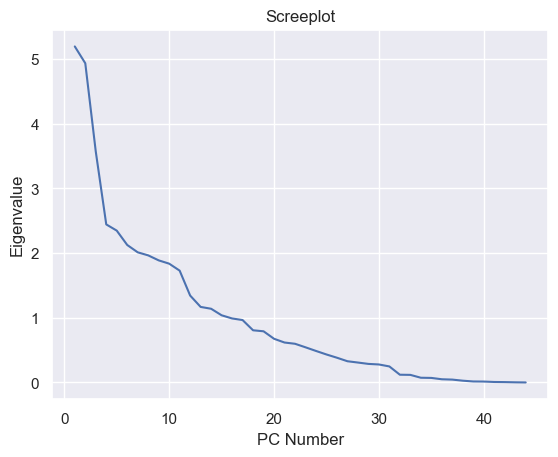

In [28]:
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
plt.title('Screeplot')
plt.xlabel('PC Number')
plt.ylabel('Eigenvalue')
plt.show()

### Identify How Many PCs To Extract <br>
#### Methods: 
##### 1) By Kaiser's Rule, extract PCs whose eigenvalues > 1
##### 2) Keep Cummulative Variance of 80%
##### 3) Scree Plot Elbow (take values on left of elbow)

In [29]:
## extract only the two PCs
pca2 = PCA(n_components=2).fit(data_reduced)
scores2 = pca2.transform(data_reduced)

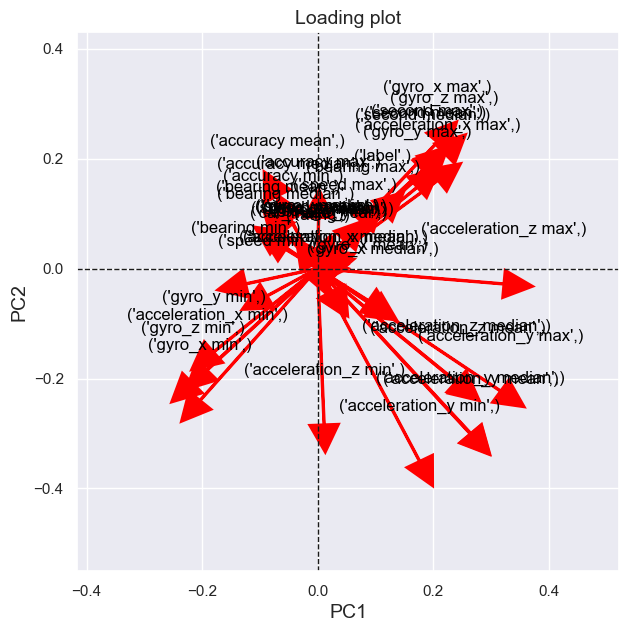

In [30]:
# This function plots the loading plot.
# Pass original data dataframe and returns of PCA to this function. Optional width, height and margin
# This function returns the axes of the loading plot

def loadingplot(data, pca, width=5, height=5, margin=0.5):

    fig, ax = plt.subplots(figsize = (width,height))

    #Set limits for figure
    x_min = min(pca.components_[0,:].min(),0)-margin
    x_max = max(pca.components_[0,:].max(),0)+margin
    y_min = min(pca.components_[1,:].min(),0)-margin
    y_max = max(pca.components_[1,:].max(),0)+margin

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    #Scaling factor for text position
    text_pos = 0.1

    for i, v in enumerate(pca.components_.T):
        ax.arrow(0, 0, v[0], v[1], head_width=0.05, head_length=0.05, linewidth=2, color='red')
        ax.text(v[0], v[1]+text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=12)

    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)
    ax.set_title("Loading plot", fontsize = 14)
    
    return ax

plt.clf
ax2 = loadingplot(data_reduced, pca2, width=7, height=7, margin=0.2)
plt.show()

## Outlier Detection

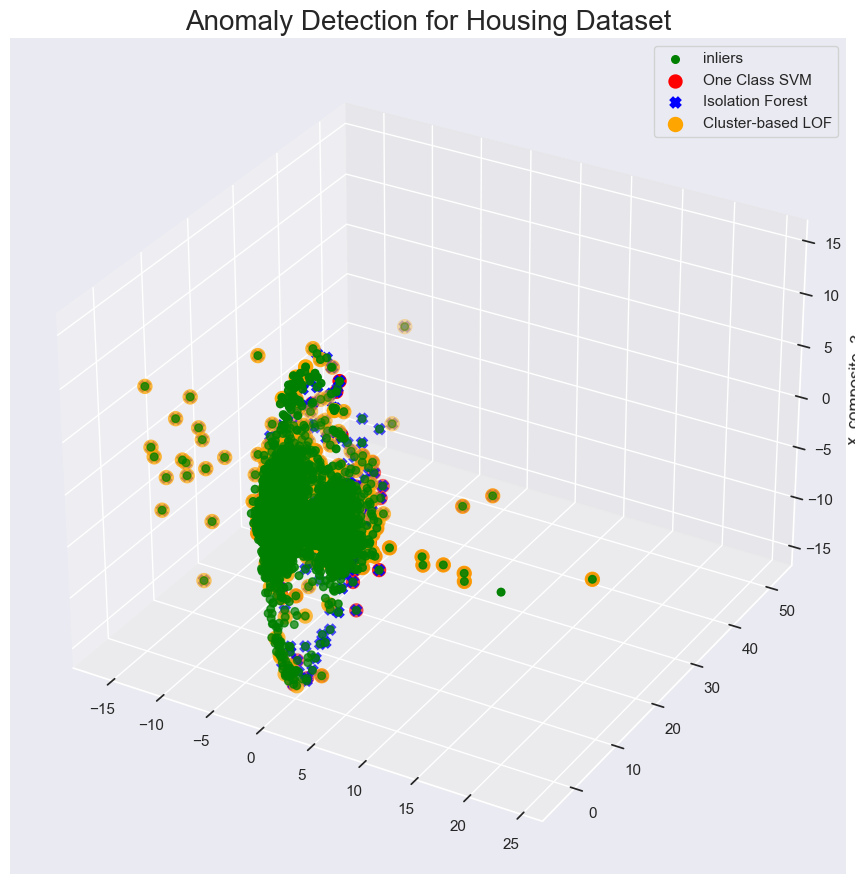

In [31]:
merge_df = merged_df.copy()

# Outlier Detection
classifier_dict = {"One-Class SVM": OneClassSVM(nu=0.05),
                   "Isolation Forest": IsolationForest(contamination=0.05),
                   "Cluster-based LOF": LocalOutlierFactor(contamination=0.05)}
Outliers = pd.DataFrame()
for i, (clf_name, clf) in enumerate(classifier_dict.items()):
    clf.fit(merge_df)
    merge_df["anomaly"] = clf.fit_predict(merge_df)
    outliers_subset = merge_df[merge_df.anomaly == -1]
    outliers_subset = outliers_subset.assign(model = clf_name)
    Outliers = pd.concat([Outliers, outliers_subset], axis=0, ignore_index=False)

pca = PCA(n_components=3) # reduce to k=3 dimensions
scaler = StandardScaler()
X = scaler.fit_transform(merged_df)
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, projection="3d")
ax.set_zlabel("x_composite_3")
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=30, lw=1, label="inliers",c="green")
ax.scatter(X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 0],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 1],
           X_reduce[Outliers[Outliers['model']=='One-Class SVM'].index, 2],
           lw=4, s=40, c="red", label="One Class SVM")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Isolation Forest'].index, 2],
           lw=4, s=40, marker='x', c="blue", label="Isolation Forest")
ax.scatter(X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 0],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 1],
           X_reduce[Outliers[Outliers['model']=='Cluster-based LOF'].index, 2],
           lw=4, s=50, c="orange", label="Cluster-based LOF")
plt.title("Anomaly Detection for Housing Dataset", fontsize=20)
plt.legend()
plt.tight_layout()

## Isolation Forest Model

In [32]:
from sklearn import metrics
from sklearn.metrics import classification_report
# load the dataset
merge_df = merged_df.copy()
# split into input and output elements
X = merge_df.drop(columns=['label'])
y = merge_df['label']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))

# identify outliers in the training dataset
iso = IsolationForest(contamination=0.05)
x_out = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]

# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
# fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))

Initial shape of the training dataset (13399, 33) (13399,)
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      4942
         1.0       0.67      0.17      0.27      1658

    accuracy                           0.77      6600
   macro avg       0.72      0.57      0.57      6600
weighted avg       0.75      0.77      0.71      6600

Shape of the training dataset after removing outliers (12729, 33) (12729,)
              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86      4942
         1.0       0.70      0.15      0.24      1658

    accuracy                           0.77      6600
   macro avg       0.73      0.56      0.55      6600
weighted avg       0.75      0.77      0.71      6600



## Local Outlier Factor Model

In [33]:
from sklearn import metrics
from sklearn.metrics import classification_report
# load the dataset
merge_df = merged_df.copy()
# split into input and output elements
X = merge_df.drop(columns=['label'])
y = merge_df['label']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))


# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.05)
x_out = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]

# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
# fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))

accuracy = metrics.accuracy_score(y_test, yhat1)

Initial shape of the training dataset (13399, 33) (13399,)
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      4942
         1.0       0.67      0.17      0.28      1658

    accuracy                           0.77      6600
   macro avg       0.72      0.57      0.57      6600
weighted avg       0.75      0.77      0.72      6600

Shape of the training dataset after removing outliers (12729, 33) (12729,)
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      4942
         1.0       0.67      0.17      0.28      1658

    accuracy                           0.77      6600
   macro avg       0.73      0.57      0.57      6600
weighted avg       0.75      0.77      0.72      6600



## One-Class SVM Model

In [34]:
from sklearn import metrics
from sklearn.metrics import classification_report
# load the dataset
merge_df = merged_df.copy()
# split into input and output elements
X = merge_df.drop(columns=['label'])
y = merge_df['label']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# summarize the shape of the training dataset
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))


# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.05)
x_out = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]

# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)
model = RandomForestClassifier()
model.fit(X_train, y_train)
# evaluate the model
yhat1 = model.predict(X_test)
# evaluate predictions
print(classification_report(y_test, yhat1))
# mape = mean_absolute_percentage_error(y_test, yhat4)
# print(f'********** One-class SVM MAPE: {mape*100:.2f}% **********')

Initial shape of the training dataset (13399, 33) (13399,)
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      4942
         1.0       0.68      0.17      0.27      1658

    accuracy                           0.77      6600
   macro avg       0.73      0.57      0.57      6600
weighted avg       0.75      0.77      0.72      6600

Shape of the training dataset after removing outliers (12729, 33) (12729,)
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86      4942
         1.0       0.68      0.17      0.28      1658

    accuracy                           0.77      6600
   macro avg       0.73      0.57      0.57      6600
weighted avg       0.75      0.77      0.72      6600



## Handling Imbalanced Data

zeros:  15007
ones:  4992


([<matplotlib.patches.Wedge at 0x1eeb088e220>,
 [Text(-0.7787637472368022, 0.7768700187223692, 'zeros'),
  Text(0.7787636745009786, -0.7768700916354897, 'ones')],
 [Text(-0.42478022576552843, 0.42374728293947406, '75.0%'),
  Text(0.4247801860914428, -0.42374732271026705, '25.0%')])

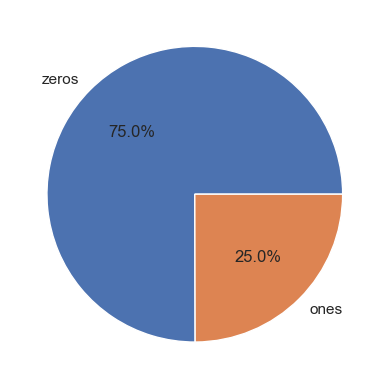

In [35]:
labels = merged_df['label']
labels = np.array(labels)
zeros, ones = 0, 0
for i in range(len(labels)):
    if labels[i] == 0:
        zeros += 1
    else:
        ones += 1
        
print('zeros: ', str(zeros))
print('ones: ', str(ones))

plt.pie([zeros, ones], labels=['zeros', 'ones'], autopct='%1.1f%%')

## Random Under Sampling

In [36]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.75, random_state=102)
# define model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
# make prediction
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.63      0.71      0.67      1263
     class 1       0.66      0.57      0.61      1233

    accuracy                           0.64      2496
   macro avg       0.64      0.64      0.64      2496
weighted avg       0.64      0.64      0.64      2496



## Random Over Sampling

In [37]:
from imblearn.over_sampling import RandomOverSampler

# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, train_size=0.75, random_state=102)
# define model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
# make prediction
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.92      0.92      0.92      3751
     class 1       0.92      0.92      0.92      3753

    accuracy                           0.92      7504
   macro avg       0.92      0.92      0.92      7504
weighted avg       0.92      0.92      0.92      7504



## Synthetic Minority Over-Sampling Technique (SMOTE)

In [38]:
from imblearn.over_sampling import SMOTE

# load the dataset
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, train_size=0.75, random_state=102)
# define model
lr_model = RandomForestClassifier()
lr_model.fit(X_train, y_train)
# make prediction
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.81      0.85      0.83      3751
     class 1       0.84      0.80      0.82      3753

    accuracy                           0.82      7504
   macro avg       0.82      0.82      0.82      7504
weighted avg       0.82      0.82      0.82      7504



# Modelling

## Final Data

In [39]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline 
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [40]:
def transformData(X , y, n_components = 13, outlier = True , pca = True, scaling = True):
      if pca:
            X = PCA(n_components = n_components).fit_transform(scale(X))

      if scaling and not pca:
            X = StandardScaler().fit_transform(X)

      ros = RandomOverSampler(random_state=42)
      X_ros, y_ros = ros.fit_resample(X, y)

      X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, train_size=0.75, random_state=102)

      if outlier:
            # identify outliers in the training dataset
            iso = IsolationForest(contamination=0.05)
            x_out = iso.fit_predict(X_train)
            # select all rows that are not outliers
            mask = (x_out != -1)
            X_train, y_train = X_train[mask], y_train[mask]

      return X_train, X_test, y_train, y_test

In [41]:
merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

X_train, X_test, y_train,y_test = transformData(X,y)

## Model Selection

In [42]:
import os

# tracking_uri = os.environ[r'c:\Users\rutsm\anaconda3\envs\pai_env_5\lib\site-packages\ipykernel_launcher.py']
# mlflow.set_tracking_uri(tracking_uri)
# logger = MLFlowLogger(
#     run_name = 'GridSearch',
#     tracking_uri = tracking_uri
# )

# baseline classifiers
classifiers = {"knn" : KNeighborsClassifier(), "SVM" : SVC(), "CART" : DecisionTreeClassifier(),
               "Logistic\nRegression": LogisticRegression(), "NaiveBayes" : GaussianNB(),
               "Random\nForest": RandomForestClassifier(), "XGBClassifier" : XGBClassifier(),
               "Adaboost": AdaBoostClassifier()}

accuracies = []
f1_scores = []

#getting baseline accuracies
for classifierName in classifiers:
    with mlflow.start_run(run_name = f'baseline model selection: {classifierName}'):
        #getting the classifier
        classifier = classifiers[classifierName]
        #fitting classifier to data
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        #print(report)
        #storing accuracy and name of classifier
        accuracies.append(report['accuracy'])
        f1_scores.append(report['0.0']['f1-score'])

        mlflow.log_metric('f1_score' , report['0.0']['f1-score'])
        mlflow.log_metric('accuracy' , report['accuracy'])
        mlflow.log_param('n_components', 13)
        mlflow.log_param('outliers' , True)

#making accuracies dict into a pandas dataframe    
df_baselines = pd.DataFrame()
df_baselines['accuracy'] = accuracies
df_baselines['f1_scores'] = f1_scores
df_baselines['classifiers'] = classifiers.keys()

df_baselines = df_baselines.melt(id_vars = ['classifiers'], value_vars=['accuracy','f1_scores'],
                                 var_name = "Type", value_name = "scores")

In [43]:
def plot(data , x_label):
    ax = sns.barplot(x = x_label,  y = 'scores', hue = "Type",data = data)
    ax.set_title("Baseline scores")
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.3f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 5),  
                        textcoords = 'offset points')
    ax.figure.autofmt_xdate()
    ax.figure.set_size_inches((14,8))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)    
    plt.show()

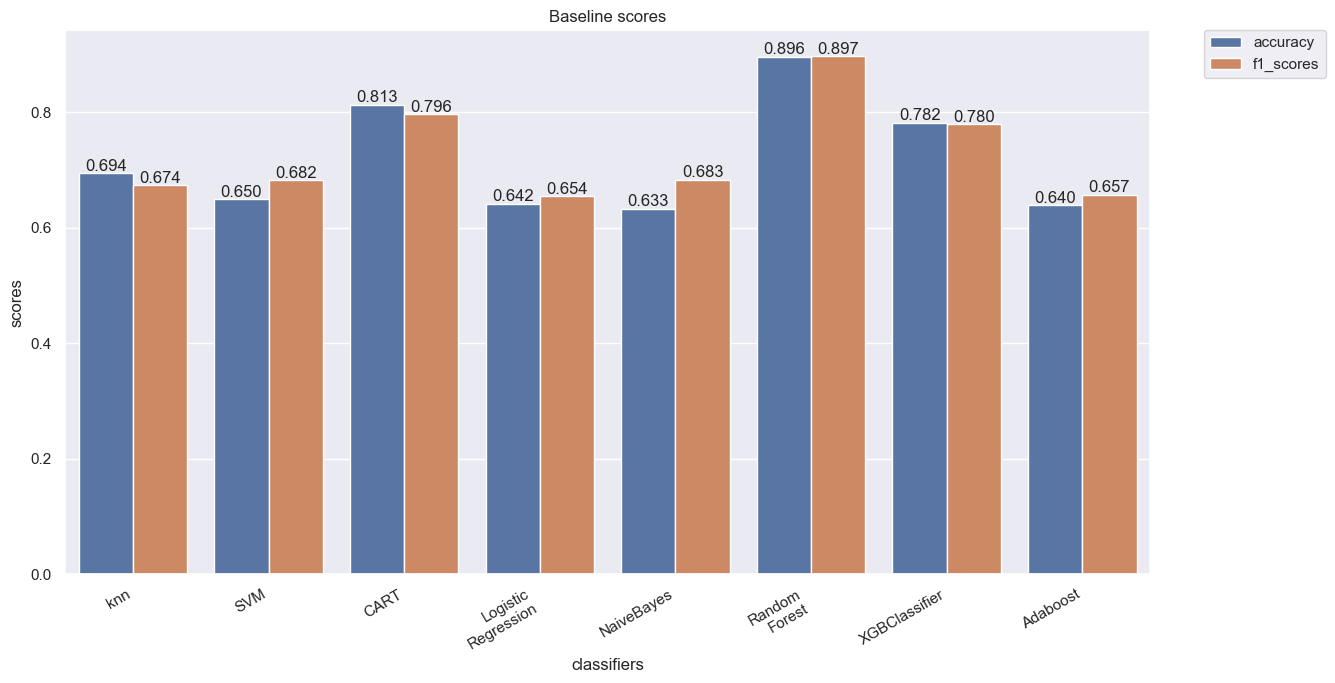

In [44]:
plot(df_baselines, 'classifiers')

In [45]:
accuracies = []
f1_scores = []

merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

for i in [True,False]:
    with mlflow.start_run(run_name = f'Outlier Detection {i}'):
        classifier = RandomForestClassifier()
        X_train, X_test, y_train,y_test = transformData(X,y, outlier = i)

        #fitting classifier to data
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        #print(report)
        #storing accuracy and name of classifier
        accuracies.append(report['accuracy'])
        f1_scores.append(report['0.0']['f1-score'])

        mlflow.log_metric('f1_score' , report['0.0']['f1-score'])
        mlflow.log_metric('accuracy' , report['accuracy'])
        mlflow.log_param('n_components', 13)
        mlflow.log_param('outliers' , i)
        

#making accuracies dict into a pandas dataframe    
df_outliers = pd.DataFrame()
df_outliers['accuracy'] = accuracies
df_outliers['f1_scores'] = f1_scores
df_outliers['outliers'] = [True , False]

df_outliers = df_outliers.melt(id_vars = ['outliers'], value_vars=['accuracy','f1_scores'],
                                 var_name = "Type", value_name = "scores")

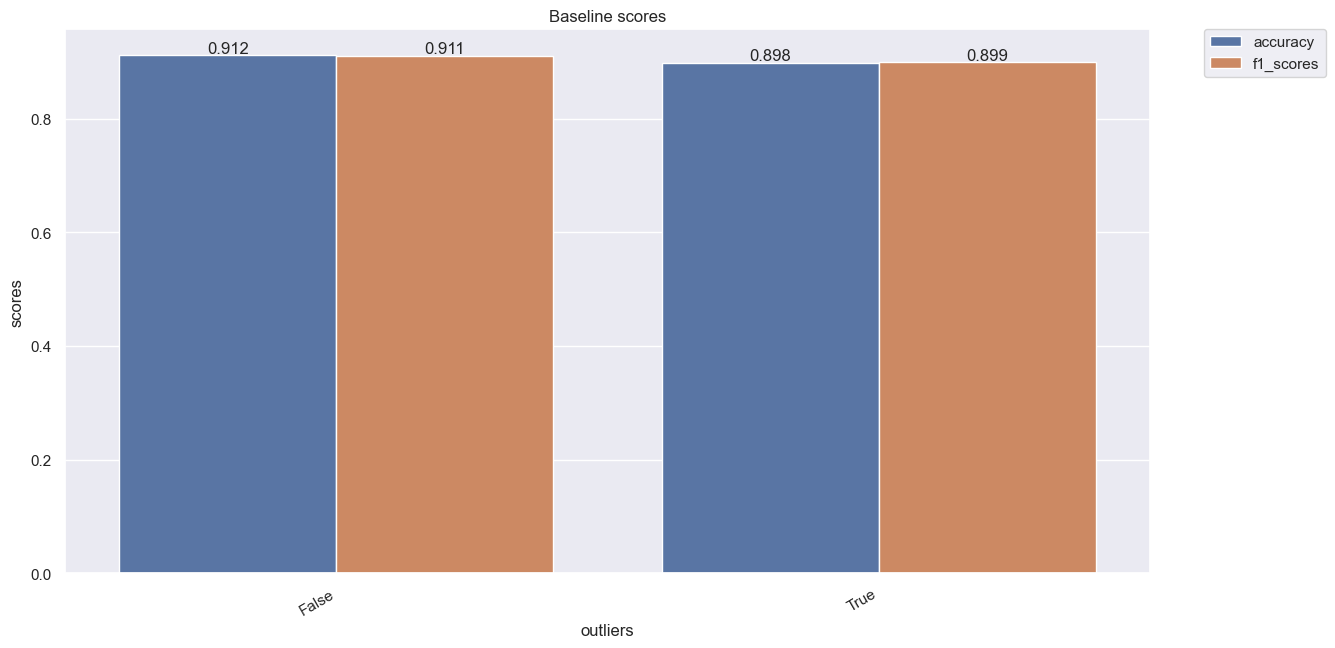

In [46]:
plot(df_outliers , "outliers")

In [47]:
accuracies = []
f1_scores = []

merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

for i in [True,False]:
    with mlflow.start_run(run_name = f'PCA {i}'):
        classifier = RandomForestClassifier()
        X_train, X_test, y_train,y_test = transformData(X,y, outlier = False , pca = i)

        #fitting classifier to data
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        #print(report)
        #storing accuracy and name of classifier
        accuracies.append(report['accuracy'])
        f1_scores.append(report['0.0']['f1-score'])

        mlflow.log_metric('f1_score' , report['0.0']['f1-score'])
        mlflow.log_metric('accuracy' , report['accuracy'])
        mlflow.log_param('n_components', 13)
        mlflow.log_param('outliers' , i)
        

#making accuracies dict into a pandas dataframe    
df_pca = pd.DataFrame()
df_pca['accuracy'] = accuracies
df_pca['f1_scores'] = f1_scores
df_pca['pca'] = [True , False]

df_pca = df_pca.melt(id_vars = ['pca'], value_vars=['accuracy','f1_scores'],
                                 var_name = "Type", value_name = "scores")

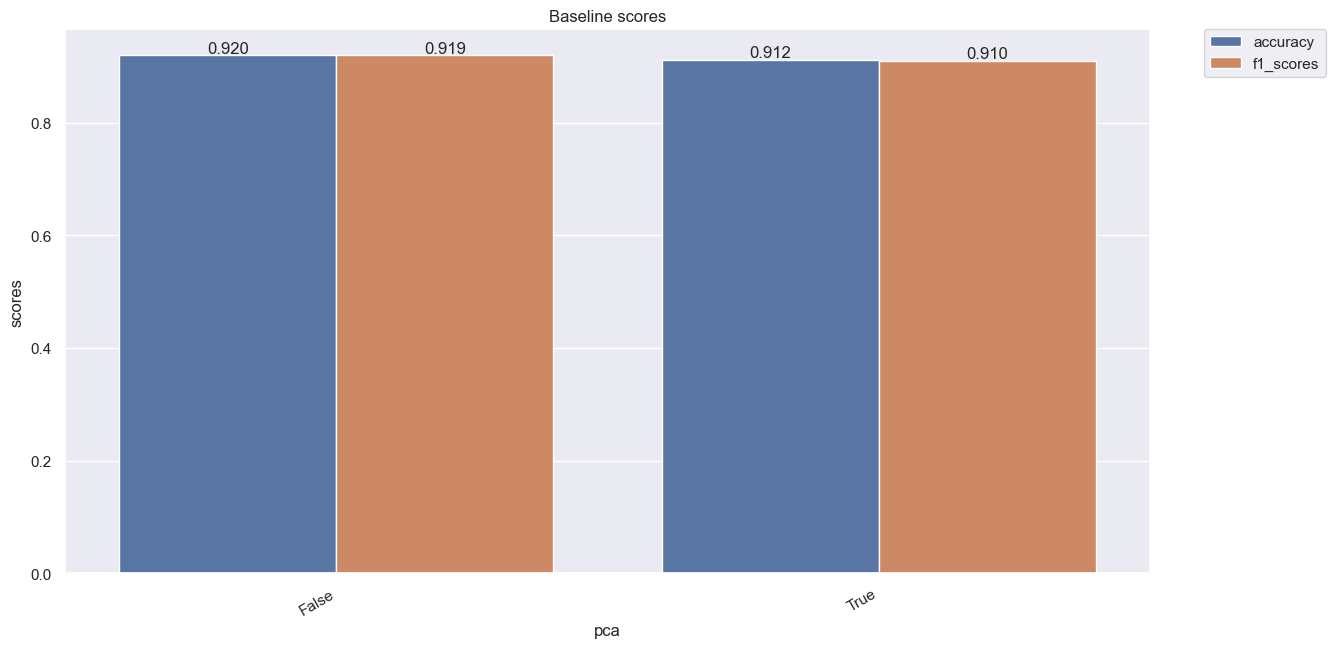

In [48]:
plot(df_pca , "pca")

In [49]:
accuracies = []
f1_scores = []

merge_df = merged_df.copy()
df = merge_df
# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]

for i in range(13,26):
    print(i)
    with mlflow.start_run(run_name = f'Component Analysis: {i}'):   
        classifier = RandomForestClassifier()
        X_train, X_test, y_train,y_test = transformData(X, y, n_components=i, outlier = False)

        #fitting classifier to data
        classifier.fit(X_train,y_train)
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        #print(report)
        #storing accuracy and name of classifier
        accuracies.append(report['accuracy'])
        f1_scores.append(report['0.0']['f1-score'])

        mlflow.log_metric('f1_score' , report['0.0']['f1-score'])
        mlflow.log_metric('accuracy' , report['accuracy'])
        mlflow.log_param('n_components', i)
        mlflow.log_param('outliers' , False)

#making accuracies dict into a pandas dataframe    
df_components = pd.DataFrame()
df_components['accuracy'] = accuracies
df_components['f1_scores'] = f1_scores
df_components['components'] = list(range(13,26))

df_components = df_components.melt(id_vars = ['components'], value_vars=['accuracy','f1_scores'],
                                 var_name = "Type", value_name = "scores")

13
14
15
16
17
18
19
20
21
22
23
24
25


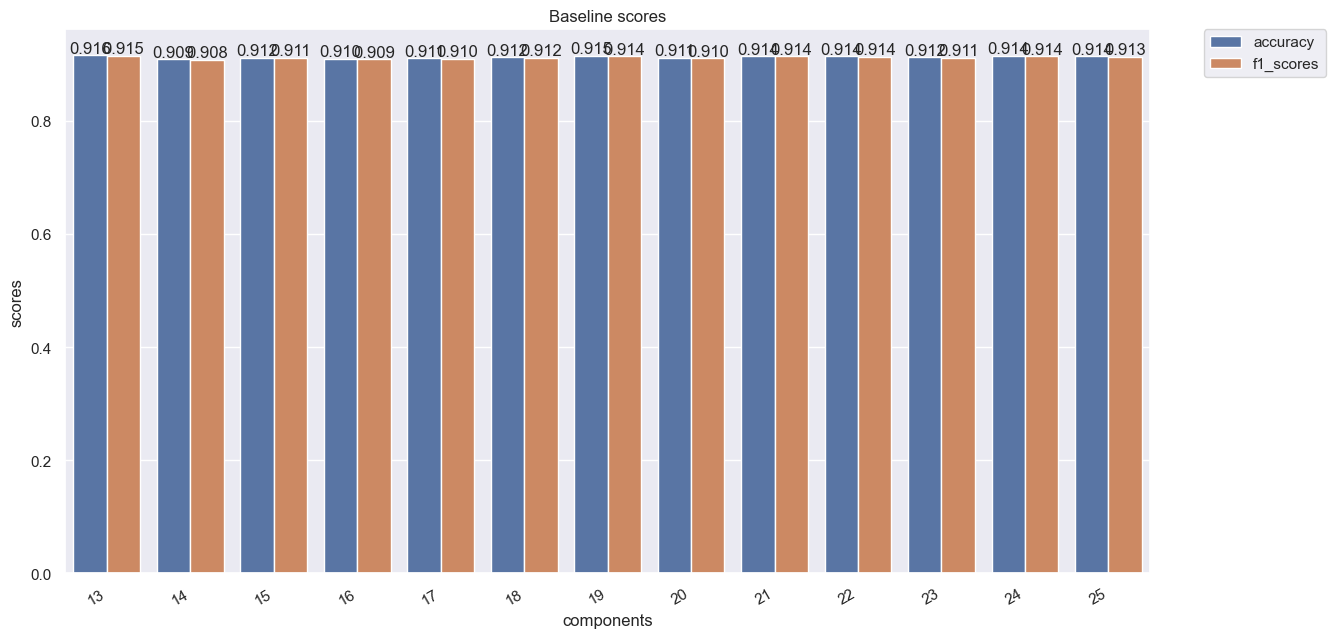

In [50]:
plot(df_components , "components")

## Hyperparameter Tuning: GridSearchCV

In [52]:
from sklearn.model_selection import GridSearchCV

# best parameters model
X_train, X_test, y_train, y_test = transformData(X,y,n_components=24, outlier = False)

crf = RandomForestClassifier(random_state=9)
param_grid = {'n_estimators': (100, 200, 500),
              'criterion': ('gini', 'entropy', 'log_loss'),
              'max_depth': (np.arange(10, 101, 20)),
              'max_features': ('auto', 'sqrt', 'log2'),
              'min_samples_leaf': (1, 2, 4)}

# Use custom random forest classifier while defining the estimator for grid search 
grid = GridSearchCV(crf, param_grid, cv=5, refit=True, scoring = 'f1', n_jobs = -1, verbose = 3, )


# # Instantiate Logger with test dataset
# logger = Logger(X_test, y_test)

# start outer mlflow run and perform grid search with cross-validation
with mlflow.start_run(run_name = "Grid Search"):
    # while calling GridSearchCV object's fit method pass logger.rf_logger
    # logger.rf_logger takes care of logging each fitted model during gridsearch
    grid.fit(X_train, y_train)

    # log the best estimator fround by grid search in the outer mlflow run 
    mlflow.log_param("n_estimators", grid.best_params_["n_estimators"])
    mlflow.log_param("criterion", grid.best_params_["criterion"])
    mlflow.log_param("max_depth", grid.best_params_["max_depth"])
    mlflow.log_param("max_features", grid.best_params_["max_features"])
    mlflow.log_param("min_samples_leaf", grid.best_params_["min_samples_leaf"]) 
    mlflow.log_metric("score", grid.score(X_test, y_test)) 

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


In [56]:
print(f'''
n_estimators: {grid.best_params_['n_estimators']}
criterion:  {grid.best_params_['criterion']}
max_depth: {grid.best_params_['max_depth']}
max_features: {grid.best_params_['max_features']}
min_samples_leaf: {grid.best_params_['min_samples_leaf']}
score: {grid.score(X_test, y_test)}
''')


n_estimators: 500
criterion:  gini
max_depth: 50
max_features: auto
min_samples_leaf: 1
score: 0.9169214409145288



## Final Model For Prediction